In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station
print(Measure)

<class 'sqlalchemy.ext.automap.measurement'>


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(Measure.date).order_by(Measure.date.desc()).first()
most_recent

('2017-08-23',)

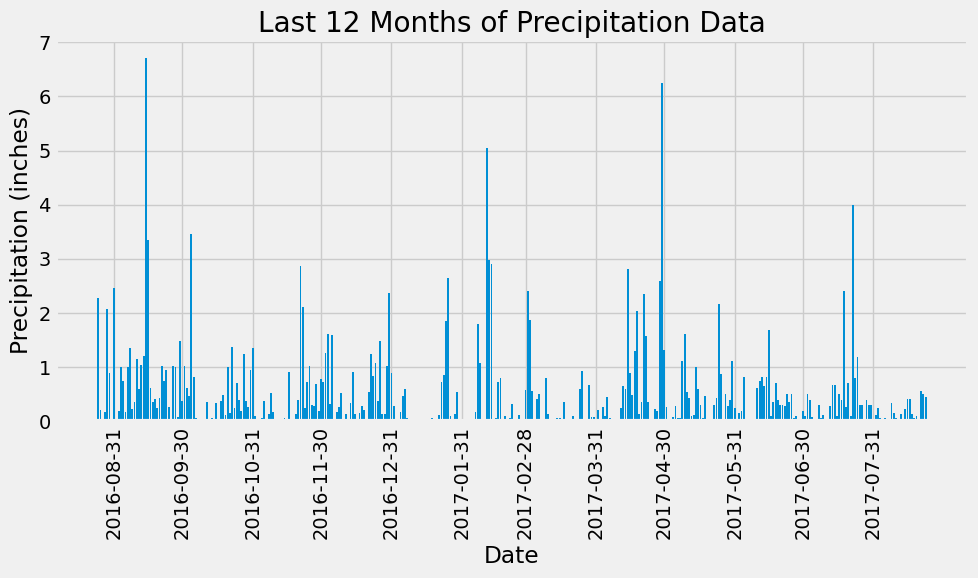

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime
# Calculate the date one year from the last date in data set.

twelve_mo_ago = datetime.datetime.strptime(most_recent.date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores

prcp_data = session.query(Measure.date, Measure.prcp).\
    filter(Measure.date >= twelve_mo_ago).\
    order_by(Measure.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
Prcp_df = pd.DataFrame(prcp_data, columns=['Date','Precipitation'])

# Sort the dataframe by date
Prcp_df = Prcp_df.sort_values('Date')
Prcp_df['Date'] = pd.to_datetime(Prcp_df['Date']) 


# Use Pandas Plotting with Matplotlib to plot the data
# Plot the results
plt.figure(figsize=(10,6))
plt.bar(Prcp_df['Date'],Prcp_df['Precipitation'], label = 'Precipitation')
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Last 12 Months of Precipitation Data")
plt.xticks(pd.date_range(start=Prcp_df['Date'].min(), end=Prcp_df['Date'].max(), freq='M'), rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
Prcp_sum_stats = Prcp_df['Precipitation'].describe()
print(Prcp_sum_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(distinct(Measure.station))).scalar()
print("Total number of stations:", station_count)

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
max_rows = session.query(Measure.station, func.count(Measure.station)).\
    group_by(Measure.station).\
    order_by(func.count(Measure.station).desc()).all()

print("Most Active Stations:")
for station, count in max_rows:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = max_rows[0][0]

temp_stats = session.query(func.min(Measure.tobs),func.max(Measure.tobs),func.avg(Measure.tobs)).\
    filter(Measure.station == most_active_station)

lowest_temp, highest_temp, avg_temp = temp_stats[0]
print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


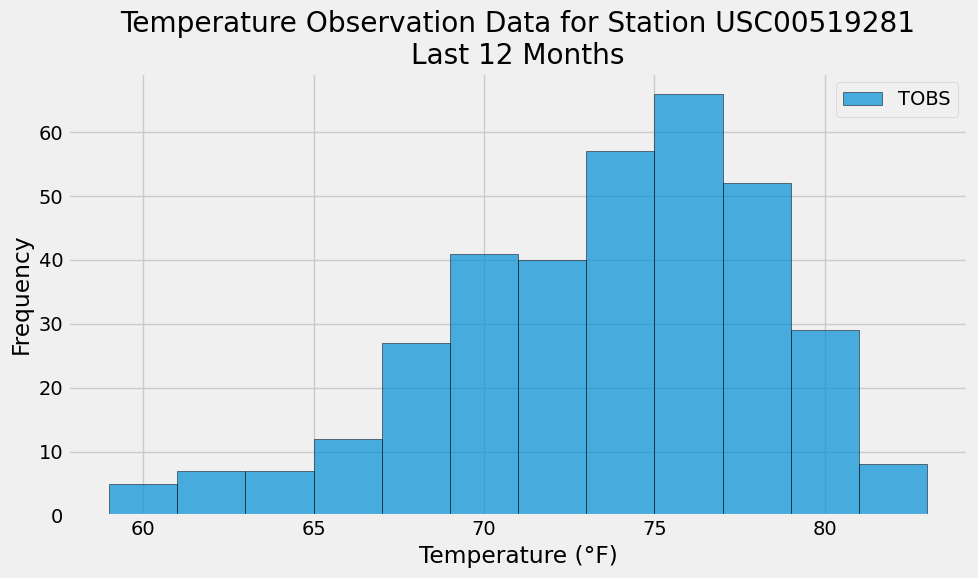

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
Temp_data = session.query(Measure.date, Measure.tobs).\
    filter(Measure.station == most_active_station).\
    filter(Measure.date >= twelve_mo_ago).\
    order_by(Measure.date).all()

Temp_df = pd.DataFrame(Temp_data, columns=['Date','Temperature'])
# plot the results as a histogram  
plt.figure(figsize=(10, 6))
plt.hist(Temp_df['Temperature'], bins=12, label='TOBS', alpha=.7, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station}\nLast 12 Months')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()